# Lesson 3

In [1]:
#import stuff
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline
import os
import utils; reload(utils)
from utils import *
from __future__ import print_function, division

Using Theano backend.


In [3]:
#setting the path to the data and the models
path = 'data/dogscats/'
model_path = path + 'model/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
model = vgg_ft(2)

In [6]:
model.load_weights(model_path+'fintune6.h5')

In [7]:
layers = model.layers

In [8]:
#get the index of the last convlution layer
last_conv_idx = [index for index, layer in enumerate(layers)
                     if type(layer)==Convolution2D][-1]

In [9]:
last_conv_idx

30

In [10]:
#get all the conv layers now that we have the last idx and create a model from it
conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)

In [11]:
#get the fully connected layers, we need them for their weights
fc_layers = layers[last_conv_idx+1:]

In [12]:
batch_size = 64

In [13]:
batches = get_batches(path+'train/', batch_size=batch_size)

Found 23000 images belonging to 2 classes.


In [14]:
val_batches = get_batches(path+'valid/', batch_size=batch_size)

Found 2000 images belonging to 2 classes.


In [24]:
train_classes = batches.classes
val_classes = val_batches.classes
train_labels = onehot(train_classes)
val_labels = onehot(val_classes)

In [26]:
??model.predict_generator

In [16]:
train_features = conv_model.predict_generator(batches, batches.N)

KeyboardInterrupt: 

In [34]:
save_array(model_path+'train_features_conv.bc', train_features)

In [37]:
val_features = conv_model.predict_generator(val_batches, val_batches.N)

In [38]:
save_array(model_path+'val_features_conv.bc', val_features)

In [17]:
train_features = load_array(model_path+'train_features_conv.bc')
val_features = load_array(model_path+'val_features_conv.bc')

In [18]:
#optimiser for the fully connected model lr will be very low as we are training a fully connected model
opt = RMSprop(lr=0.00001, rho=0.7)

In [19]:
#method to get weights
#note : I am fairly sure that this is the rescaling of weights. Since Keras automatically does that we might not need to divide by 2 here. 
def proc_weights(layer): return [o/2 for o in layer.get_weights()]

In [20]:
def get_fc_model():
    model = Sequential([
            MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.),
            Dense(4096, activation='relu'),
            Dropout(0.),
            Dense(2, activation='softmax')
        ])
    
    for l1, l2 in zip(model.layers, fc_layers): l1.set_weights(proc_weights(l2))
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
fc_model = get_fc_model()

In [31]:
fc_model.fit(train_features, train_labels, batch_size=batch_size, nb_epoch=2, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/2
23000/23000 [==============================] - 33s - loss: 0.1629 - acc: 0.9548 - val_loss: 2.4226 - val_acc: 0.4795
Epoch 2/2
23000/23000 [==============================] - 33s - loss: 0.1760 - acc: 0.9529 - val_loss: 2.7844 - val_acc: 0.4925


In [29]:
fc_model.save_weights(model_path+'no_dropout.h5')

In [35]:
val_features.shape

(2000, 512, 14, 14)

In [36]:
??image.ImageDataGenerator

## Data Augmentation

In [44]:
# Doing it for single image
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.0,shear_range=0.15, height_shift_range=0.1, zoom_range=0.1, channel_shift_range=10., horizontal_flip=True, dim_ordering='tf')


In [42]:
img = np.expand_dims(ndimage.imread('data/dogscats/test1/data/7.jpg'), 0)

In [45]:
aug_iter = gen.flow(img)

In [51]:
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

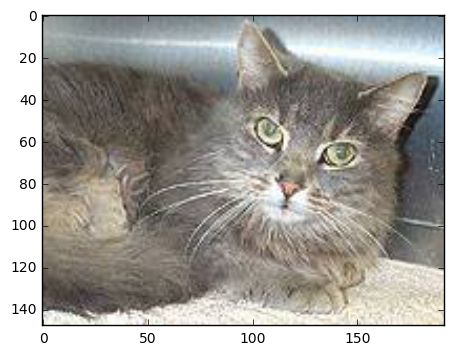

In [53]:
plt.imshow(img[0])

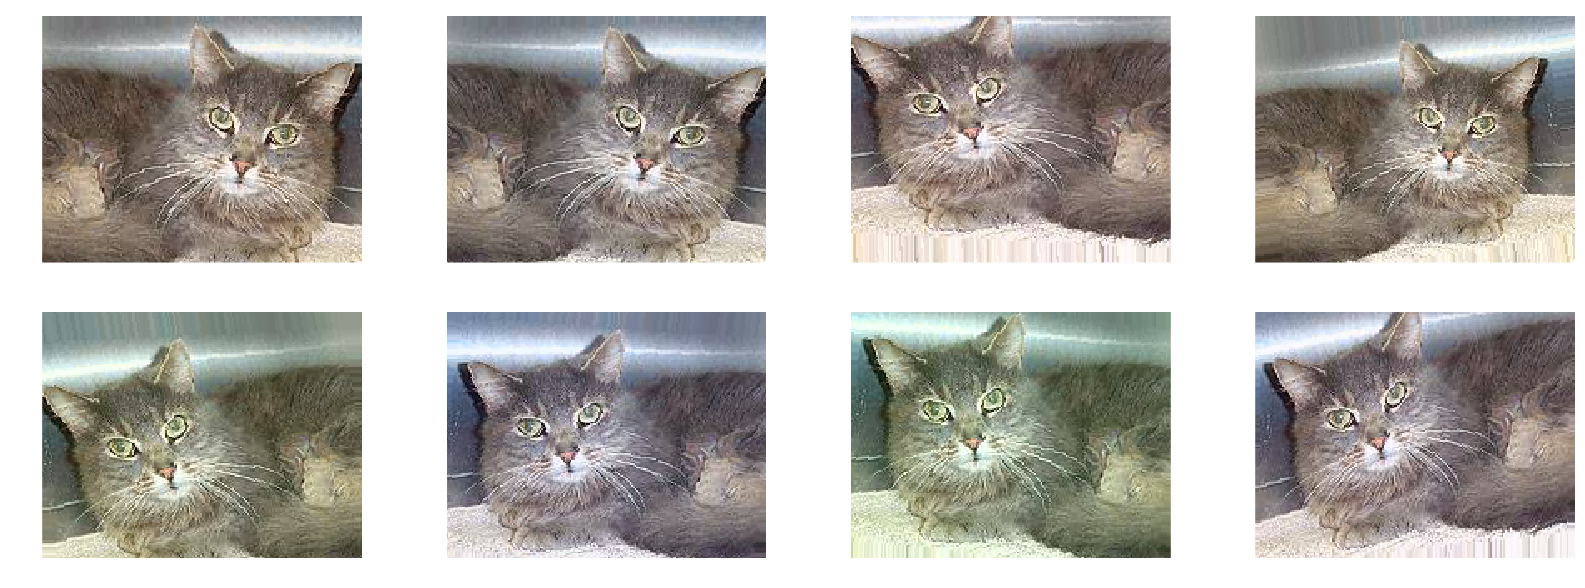

In [54]:
plots(aug_imgs, (20, 7), 2)

In [58]:
#revert back to theano dim ordering
K.set_image_dim_ordering = 'th'

In [60]:
#Adding data augmentation to our model

gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [62]:
batches = get_batches(path+'train/', gen, batch_size=batch_size, shuffle=True)

Found 23000 images belonging to 2 classes.


In [64]:
val_batches = get_batches(path+'valid/', batch_size=batch_size, shuffle=False)

Found 2000 images belonging to 2 classes.


In [65]:
fc_model = get_fc_model()

In [66]:
for layer in conv_model.layers: layer.trainable = False

In [68]:
conv_model.add(fc_model)

In [70]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=8, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/8
23000/23000 [==============================] - 619s - loss: 0.1547 - acc: 0.9800 - val_loss: 0.1084 - val_acc: 0.9865
Epoch 2/8
23000/23000 [==============================] - 619s - loss: 0.0843 - acc: 0.9861 - val_loss: 0.1136 - val_acc: 0.9860
Epoch 3/8
23000/23000 [==============================] - 620s - loss: 0.0587 - acc: 0.9899 - val_loss: 0.1466 - val_acc: 0.9830
Epoch 4/8
23000/23000 [==============================] - 620s - loss: 0.0514 - acc: 0.9907 - val_loss: 0.1468 - val_acc: 0.9855
Epoch 5/8
23000/23000 [==============================] - 620s - loss: 0.0449 - acc: 0.9928 - val_loss: 0.1451 - val_acc: 0.9850
Epoch 6/8
23000/23000 [==============================] - 620s - loss: 0.0389 - acc: 0.9937 - val_loss: 0.1502 - val_acc: 0.9840
Epoch 7/8
23000/23000 [==============================] - 620s - loss: 0.0345 - acc: 0.9948 - val_loss: 0.1913 - val_acc: 0.9830
Epoch 8/8
23000/23000 [==============================] - 620s - loss: 0.0298 - acc: 0.9952 - val_loss: 0

In [75]:
conv_model.save_weights(model_path+'aug_8.h5')

## Batch Normalisation

In [76]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1000, activation='softmax')
    ]

In [78]:
def load_fc_weights_from_vggbn(model):
    from vgg16bn import Vgg16BN
    vgg_bn = Vgg16BN()
    _, fc_layers = split_at(vgg_bn.model, Convolution2D)
    copy_weights(fc_layers, model.layers)

In [95]:
p = 0.6

In [96]:
bn_model = Sequential(get_bn_layers(0.6))

In [97]:
load_fc_weights_from_vggbn(bn_model)

In [84]:
def proc_wgts(layer, prev_drop, new_drop):
    scale = (1-prev_drop)/(1-new_drop)
    return [o*scale for o in layer.get_weights()]

In [85]:
for l in bn_model.layers:
   if type(l) == Dense: l.set_weights(proc_wgts(l, 0.5, p))

In [98]:
bn_model.pop()
for layer in bn_model.layers: layer.trainable = False

#We are only going to train the last dense layer
bn_model.add(Dense(2, activation='softmax'))

In [99]:
bn_model.compile(Adam(), 'categorical_crossentropy', ['accuracy'])

In [100]:
bn_model.fit(train_features, train_labels, nb_epoch=8, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 12s - loss: 2.0058 - acc: 0.4985 - val_loss: 1.0363 - val_acc: 0.5185
Epoch 2/8
23000/23000 [==============================] - 12s - loss: 1.7115 - acc: 0.4973 - val_loss: 1.0694 - val_acc: 0.4975
Epoch 3/8
23000/23000 [==============================] - 12s - loss: 1.6750 - acc: 0.5013 - val_loss: 1.0521 - val_acc: 0.5015
Epoch 4/8
23000/23000 [==============================] - 12s - loss: 1.6860 - acc: 0.5028 - val_loss: 1.0893 - val_acc: 0.4885
Epoch 5/8
23000/23000 [==============================] - 12s - loss: 1.6763 - acc: 0.5036 - val_loss: 1.1068 - val_acc: 0.4915
Epoch 6/8
23000/23000 [==============================] - 12s - loss: 1.7140 - acc: 0.4965 - val_loss: 1.1519 - val_acc: 0.4950
Epoch 7/8
23000/23000 [==============================] - 12s - loss: 1.6969 - acc: 0.5012 - val_loss: 1.0487 - val_acc: 0.5095
Epoch 8/8
23000/23000 [==============================] - 12s -

In [101]:
#creating the final model
final_model = Sequential(conv_layers)

In [102]:
for layer in final_model.layers: layer.trainable = False

In [103]:
#we are creating new bn_layers so that we can train all the layers
bn_layers = get_bn_layers(p)
bn_layers.pop()
bn_layers.append(Dense(2, activation='softmax'))

In [105]:
bn_layers

In [107]:
bn_model.layers

AttributeError: 'list' object has no attribute 'summary'

In [104]:
#copy weights from the previous model
for l1, l2 in zip(bn_layers, bn_model.layers):
    l1.set_weights(l2.get_weights())

Exception: You called `set_weights(weights)` on layer "dense_32" with a  weight list of length 2, but the layer was expecting 0 weights. Provided weights: [array([[-0.0007,  0.0024, -0.002 , ...,  0.0019, ...

In [ ]:
for l in bn_layers:
    final_model.add(l)

In [ ]:
final_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=8, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
final_model.save_weights(model_path+'final1.h5')